1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
pd.set_option('display.max_columns', 200)

2. Helper Functions

In [ ]:
def normalize_name(x):
    if pd.isna(x):
        return x
    return str(x).strip().lower()

3. Load Data

In [ ]:
help_df = pd.read_csv("/content/help_network.csv")
avoid_df = pd.read_csv("/content/avoid_network.csv")
companion_df = pd.read_csv("/content/companion_plants.csv")
companion_veg_df = pd.read_csv("/content/companion_plants_veg.csv")
rankings_df = pd.read_csv("/content/final_plant_rankings.csv")
print("help_df columns:", help_df.columns.tolist())
print("avoid_df columns:", avoid_df.columns.tolist())
print("rankings_df columns:", rankings_df.columns.tolist())
print(rankings_df.head())

help_df columns: ['Source Node', 'Destination Node']
avoid_df columns: ['Source Node', 'Destination Node']
rankings_df columns: ['Plant', 'Help_Rank', 'Avoid_Rank']
             Plant  Help_Rank  Avoid_Rank
0  "flower strips"   0.001089         NaN
1          alfalfa        NaN    0.006619
2          alliums   0.009932    0.018880
3  alliums (chives   0.001089         NaN
4          alyssum   0.002496         NaN


4. Clean the data

In [ ]:
for df in [help_df, avoid_df, companion_df, companion_veg_df]:
    for col in ["Source Node", "Destination Node", "Source", "Destination", "source", "dest"]:
        if col in df.columns:
            df[col] = df[col].apply(normalize_name)

if "Plant" in rankings_df.columns:
    rankings_df["Plant"] = rankings_df["Plant"].apply(normalize_name)
else:
    raise KeyError("final_plant_rankings.csv must contain a 'Plant' column")

In [ ]:
for col in ["Help_Rank", "Avoid_Rank"]:
    if col in rankings_df.columns:
        rankings_df[col] = pd.to_numeric(rankings_df[col], errors='coerce')
    else:
        rankings_df[col] = np.nan

5. Create graph

In [ ]:
G = nx.Graph()

def add_edges_from_df(df, src_col, dst_col, relation):
    if src_col in df.columns and dst_col in df.columns:
        for _, r in df[[src_col, dst_col]].dropna().iterrows():
            s = r[src_col]
            d = r[dst_col]
            if s == "" or d == "":
                continue
            G.add_edge(s, d, relation=relation)

add_edges_from_df(help_df, "Source Node", "Destination Node", "help")
add_edges_from_df(avoid_df, "Source Node", "Destination Node", "avoid")
add_edges_from_df(companion_df, "Source Node", "Destination Node", "help")
add_edges_from_df(companion_veg_df, "Source Node", "Destination Node", "help")

print(f"Graph built: nodes={len(G.nodes())}, edges={len(G.edges())}")

Graph built: nodes=290, edges=1014


6. Graph Features

In [ ]:
betweenness = nx.betweenness_centrality(G)   # O(n*m) worst-case
closeness = nx.closeness_centrality(G)
clustering = nx.clustering(G)
pagerank = nx.pagerank(G)

In [ ]:
features = []
for node in G.nodes():
    edges_list = list(G.edges(node, data=True))
    help_degree = sum(1 for _, _, d in edges_list if d.get("relation") == "help")
    avoid_degree = sum(1 for _, _, d in edges_list if d.get("relation") == "avoid")
    deg = G.degree(node)
    help_ratio = help_degree / deg if deg > 0 else 0.0
    avoid_ratio = avoid_degree / deg if deg > 0 else 0.0
    features.append({
        "plant": node,
        "degree": deg,
        "help_degree": help_degree,
        "avoid_degree": avoid_degree,
        "net_helpfulness": help_degree - avoid_degree,
        "help_ratio": help_ratio,
        "avoid_ratio": avoid_ratio,
        "betweenness": betweenness.get(node, 0.0),
        "closeness": closeness.get(node, 0.0),
        "clustering": clustering.get(node, 0.0),
        "pagerank": pagerank.get(node, 0.0)
    })
features_df = pd.DataFrame(features)
print("features_df preview:")
print(features_df.head())

features_df preview:
         plant  degree  help_degree  avoid_degree  net_helpfulness  \
0      alliums      26           25             1               24   
1  fruit trees      12           12             0               12   
2  nightshades      18           16             2               14   
3     tomatoes      73           71             2               69   
4      peppers      31           29             2               27   

   help_ratio  avoid_ratio  betweenness  closeness  clustering  pagerank  
0    0.961538     0.038462     0.048716   0.427515    0.175385  0.013082  
1    1.000000     0.000000     0.010733   0.351154    0.015152  0.005819  
2    0.888889     0.111111     0.018961   0.408192    0.156863  0.008420  
3    0.972603     0.027397     0.185535   0.526412    0.118721  0.031890  
4    0.935484     0.064516     0.057082   0.434586    0.126882  0.015102  


7. Merge Data

In [ ]:
merged_df = features_df.merge(rankings_df[["Plant", "Help_Rank", "Avoid_Rank"]],
                              left_on="plant", right_on="Plant", how="inner")
print("Merged rows:", merged_df.shape[0])
print(merged_df[['plant','Help_Rank','Avoid_Rank']].head())
merged_df = merged_df.dropna(subset=["Help_Rank"]).reset_index(drop=True)
print("After dropping missing Help_Rank:", merged_df.shape[0])

Merged rows: 260
         plant  Help_Rank  Avoid_Rank
0      alliums   0.009932    0.018880
1  fruit trees   0.006300         NaN
2  nightshades   0.005009    0.025480
3     tomatoes   0.050112    0.048725
4      peppers   0.029272    0.026086
After dropping missing Help_Rank: 229


8. Data Prep

In [ ]:
feature_cols = ["degree", "help_degree", "avoid_degree", "net_helpfulness",
                "help_ratio", "avoid_ratio", "betweenness", "closeness",
                "clustering", "pagerank", "Avoid_Rank"]
merged_df["Avoid_Rank"] = merged_df["Avoid_Rank"].fillna(merged_df["Avoid_Rank"].median())
merged_df[feature_cols] = merged_df[feature_cols].fillna(0)
X = merged_df[feature_cols].copy()
y = merged_df["Help_Rank"].copy()
print("X shape:", X.shape, "y shape:", y.shape)
print("Feature sample:\n", X.head())

X shape: (229, 11) y shape: (229,)
Feature sample:
    degree  help_degree  avoid_degree  net_helpfulness  help_ratio  \
0      26           25             1               24    0.961538   
1      12           12             0               12    1.000000   
2      18           16             2               14    0.888889   
3      73           71             2               69    0.972603   
4      31           29             2               27    0.935484   

   avoid_ratio  betweenness  closeness  clustering  pagerank  Avoid_Rank  
0     0.038462     0.048716   0.427515    0.175385  0.013082    0.018880  
1     0.000000     0.010733   0.351154    0.015152  0.005819    0.008260  
2     0.111111     0.018961   0.408192    0.156863  0.008420    0.025480  
3     0.027397     0.185535   0.526412    0.118721  0.031890    0.048725  
4     0.064516     0.057082   0.434586    0.126882  0.015102    0.026086  


9. Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])

Train rows: 183 Test rows: 46


10. Train Models

In [ ]:
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=200, random_state=42)

11. Check Models

In [ ]:
def evaluate(model, X_t, y_t, name="model"):
    yhat = model.predict(X_t)
    mse = mean_squared_error(y_t, yhat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_t, yhat)
    mae = mean_absolute_error(y_t, yhat)
    print(f"{name}: RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
    return yhat
print("Evaluation on test set:")
yhat_xgb = evaluate(xgb_model, X_test, y_test, "XGBoost")
yhat_rf  = evaluate(rf_model,  X_test, y_test, "RandomForest")

Evaluation on test set:
XGBoost: RMSE=0.0049, MSE=0.0000, MAE=0.0023, R2=0.5836
RandomForest: RMSE=0.0052, MSE=0.0000, MAE=0.0024, R2=0.5335


12. Add Predictions

In [ ]:
merged_df["Pred_HelpRank_XGB"] = xgb_model.predict(X)
merged_df["Pred_HelpRank_RF"]  = rf_model.predict(X)
print(merged_df[["plant","Help_Rank","Avoid_Rank","Pred_HelpRank_XGB","Pred_HelpRank_RF"]].head())

         plant  Help_Rank  Avoid_Rank  Pred_HelpRank_XGB  Pred_HelpRank_RF
0      alliums   0.009932    0.018880           0.011027          0.015662
1  fruit trees   0.006300    0.008260           0.005920          0.005385
2  nightshades   0.005009    0.025480           0.004703          0.005800
3     tomatoes   0.050112    0.048725           0.048740          0.043182
4      peppers   0.029272    0.026086           0.029005          0.026058


13. Check Model Results

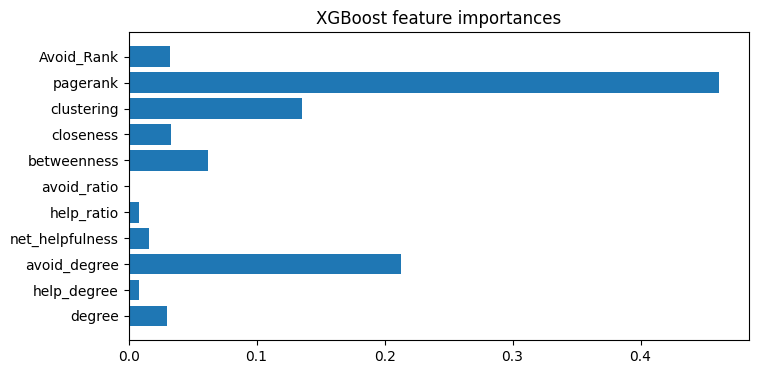

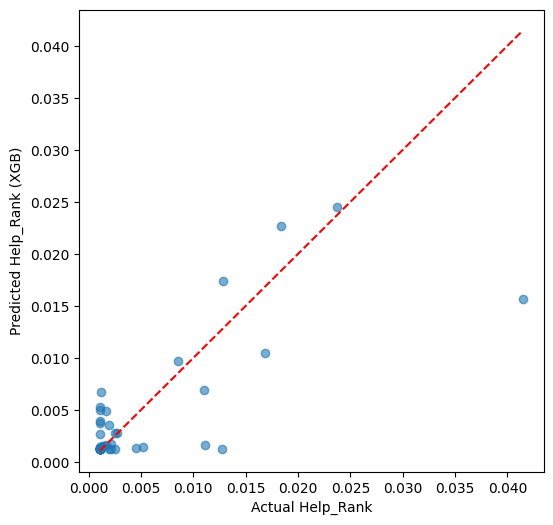

In [ ]:
fi = xgb_model.feature_importances_
plt.figure(figsize=(8,4))
plt.barh(feature_cols, fi)
plt.title("XGBoost feature importances")
plt.show()
plt.figure(figsize=(6,6))
plt.scatter(y_test, yhat_xgb, alpha=0.6)
plt.xlabel("Actual Help_Rank")
plt.ylabel("Predicted Help_Rank (XGB)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()

14. Save Models

In [ ]:
joblib.dump(xgb_model, "/content/xgb_model.pkl")
joblib.dump(rf_model, "/content/rf_model.pkl")
print("Models saved to /content/")

Models saved to /content/


15. Reload Saved Models

In [ ]:
xgb_loaded = joblib.load("/content/xgb_model.pkl")
rf_loaded  = joblib.load("/content/rf_model.pkl")
print("Models reloaded successfully!")

Models reloaded successfully!


16. Test on a sample row

In [ ]:
sample = X_test.iloc[[0]]
print("\nSample Test Row:")
print(sample)
print("\nActual Help_Rank:", y_test.iloc[0])
print("XGB Prediction:", xgb_loaded.predict(sample)[0])
print("RF Prediction:", rf_loaded.predict(sample)[0])


Sample Test Row:
     degree  help_degree  avoid_degree  net_helpfulness  help_ratio  \
216       1            1             0                1         1.0   

     avoid_ratio  betweenness  closeness  clustering  pagerank  Avoid_Rank  
216          0.0          0.0     0.2755         0.0  0.000954     0.00826  

Actual Help_Rank: 0.0010892162062171
XGB Prediction: 0.0012094466
RF Prediction: 0.0011349976501919227


17. Predict on Full Dataset

In [ ]:
merged_df["Pred_HelpRank_XGB_Loaded"] = xgb_loaded.predict(X)
merged_df["Pred_HelpRank_RF_Loaded"]  = rf_loaded.predict(X)

18. Save Predictions to csv

In [ ]:
output_path = "/content/final_predictions.csv"
merged_df.to_csv(output_path, index=False)
print(f"\nPredictions saved to {output_path}")


Predictions saved to /content/final_predictions.csv


19. Preview

In [ ]:
print(merged_df[["plant","Help_Rank","Avoid_Rank","Pred_HelpRank_XGB_Loaded","Pred_HelpRank_RF_Loaded"]].head())

         plant  Help_Rank  Avoid_Rank  Pred_HelpRank_XGB_Loaded  \
0      alliums   0.009932    0.018880                  0.011027   
1  fruit trees   0.006300    0.008260                  0.005920   
2  nightshades   0.005009    0.025480                  0.004703   
3     tomatoes   0.050112    0.048725                  0.048740   
4      peppers   0.029272    0.026086                  0.029005   

   Pred_HelpRank_RF_Loaded  
0                 0.015662  
1                 0.005385  
2                 0.005800  
3                 0.043182  
4                 0.026058  
